In [2]:
import pandas as pd
import pyarrow.feather as feather
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import gcsfs
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
from sklearn.metrics import roc_curve, precision_recall_curve
# from google.colab import files


In [3]:
fs = gcsfs.GCSFileSystem()
with fs.open('gs://amex_data/train_data.ftr') as f:
    train = feather.read_feather(f)

In [4]:

train_labels = pd.read_csv('gs://amex_data/train_labels.csv')

In [5]:
train_labels.head(5)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [5]:
train.shape

(5531451, 191)

In [6]:
train.target.value_counts(normalize = True)

target
0    0.750903
1    0.249097
Name: proportion, dtype: float64

In [10]:
train.isna().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_142          4587043
D_143           101548
D_144            40727
D_145           101548
target               0
Length: 191, dtype: int64

In [7]:
train.head(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


#### The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:\

D_* = Delinquency variables\
S_* = Spend variables\
P_* = Payment variables\
B_* = Balance variables\
R_* = Risk variables

In [8]:
target_class = pd.DataFrame({
    'count': train['target'].value_counts(), 
    'Percentage': train['target'].value_counts(normalize=True) * 100
})


In [6]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
fea_D = [d for d in train.columns if d.startswith('D_')]
fea_S = [s for s in train.columns if s.startswith('S_')]
fea_P = [p for p in train.columns if p.startswith('P_')]
fea_B = [b for b in train.columns if b.startswith('B_')]
fea_R = [r for r in train.columns if r.startswith('R_')]
print(f'Total number of Delinquency variables: {len(fea_D)}')
print(f'Total number of Spend variables: {len(fea_S)}')
print(f'Total number of Payment variables: {len(fea_P)}')
print(f'Total number of Balance variables: {len(fea_B)}')
print(f'Total number of Risk variables: {len(fea_R)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


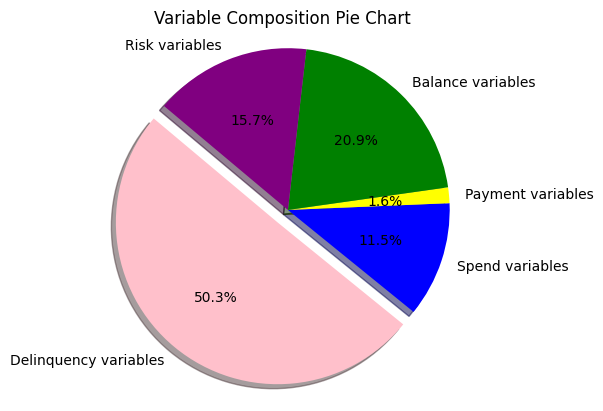

In [9]:
labels = 'Delinquency variables','Spend variables','Payment variables', 'Balance variables', 'Risk variables'
sized = len(fea_D)/len(train.columns)
sizes = len(fea_S)/len(train.columns)
sizep = len(fea_P)/len(train.columns)
sizeb = len(fea_B)/len(train.columns)
sizer = 1 - sized - sizes - sizep - sizeb

sizeq = [sized,sizes,sizep,sizeb,sizer]  # Percentages of each segment
colors = ['Pink', 'Blue', 'Yellow', 'Green', 'Purple']
explode = (0.1, 0,0,0,0)  # explode 1st slice

# Plot
plt.pie(sizeq, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Variable Composition Pie Chart')
plt.show()

In [10]:
# temp = train.groupby([f, 'target']).size().unstack(fill_value=0)
# temp

/var/tmp/ipykernel_144681/3821959660.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = train.groupby([f, 'target']).size().unstack(fill_value=0)
/var/tmp/ipykernel_144681/3821959660.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = train.groupby([f, 'target']).size().unstack(fill_value=0)
/var/tmp/ipykernel_144681/3821959660.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = train.groupby([f, 't

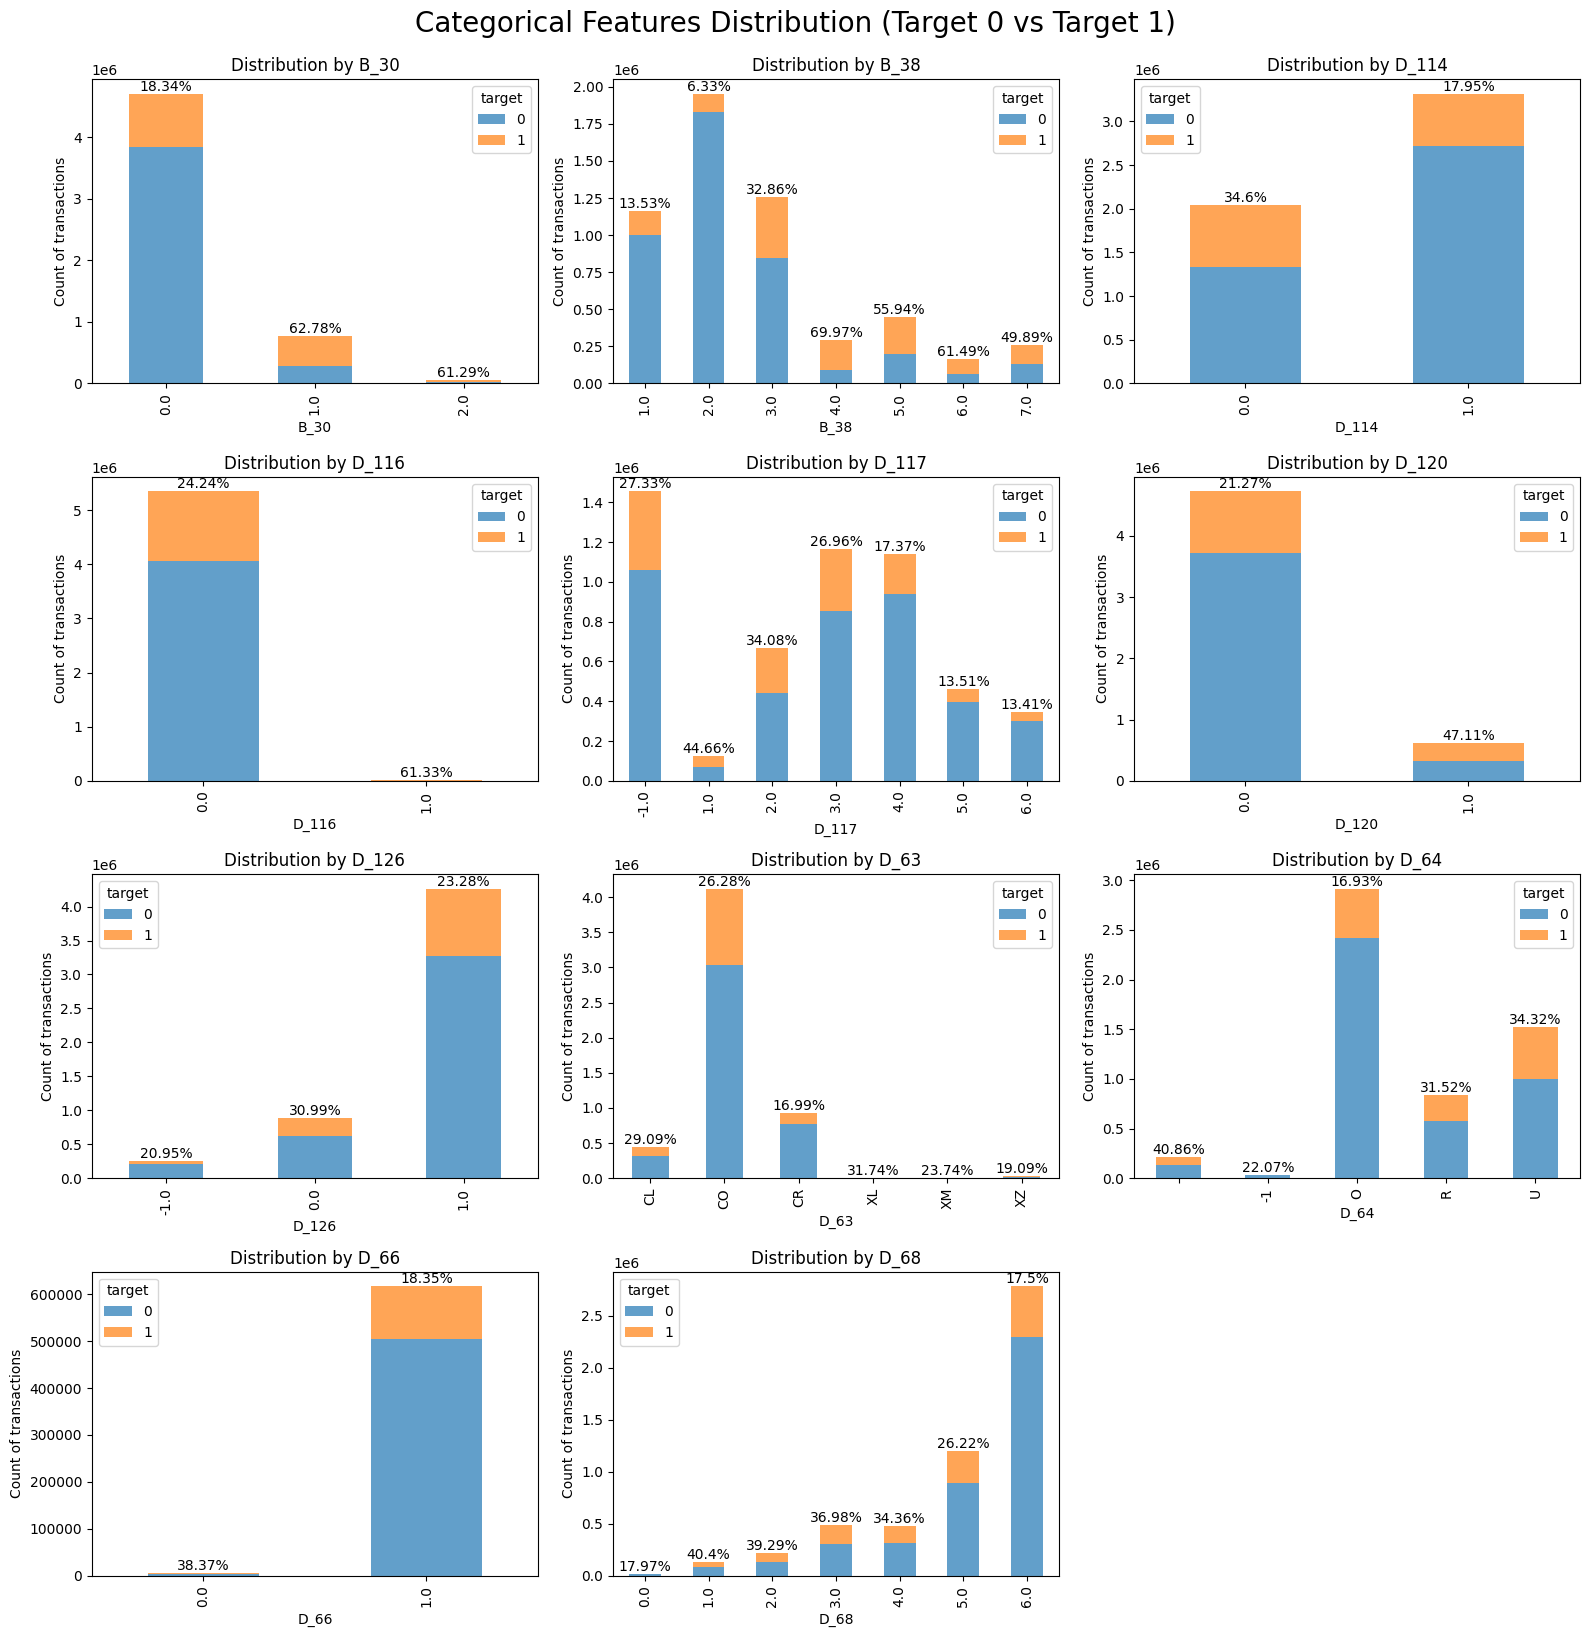

In [11]:
plt.figure(figsize=(16, 16))

for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = train.groupby([f, 'target']).size().unstack(fill_value=0)
    temp.plot(kind='bar', stacked=True, ax=plt.gca(), alpha=0.7, color=['#1f77b4', '#ff7f0e'])
    percentages = np.round(temp[1] / (temp[1]+temp[0]) * 100, 2)

    for idx, value in enumerate(percentages):
        plt.text(idx, temp[0].iloc[idx] + temp[1].iloc[idx], f'{value}%', ha='center', va='bottom')
        
    plt.xlabel(f)
    plt.ylabel("Count of transactions")
    plt.title(f"Distribution by {f}")

plt.tight_layout()
plt.suptitle('Categorical Features Distribution (Target 0 vs Target 1)', fontsize=20, y=1.02)
plt.show()


In [12]:
print(train['S_2'].min(), train['S_2'].max())

2017-03-01 00:00:00 2018-03-31 00:00:00


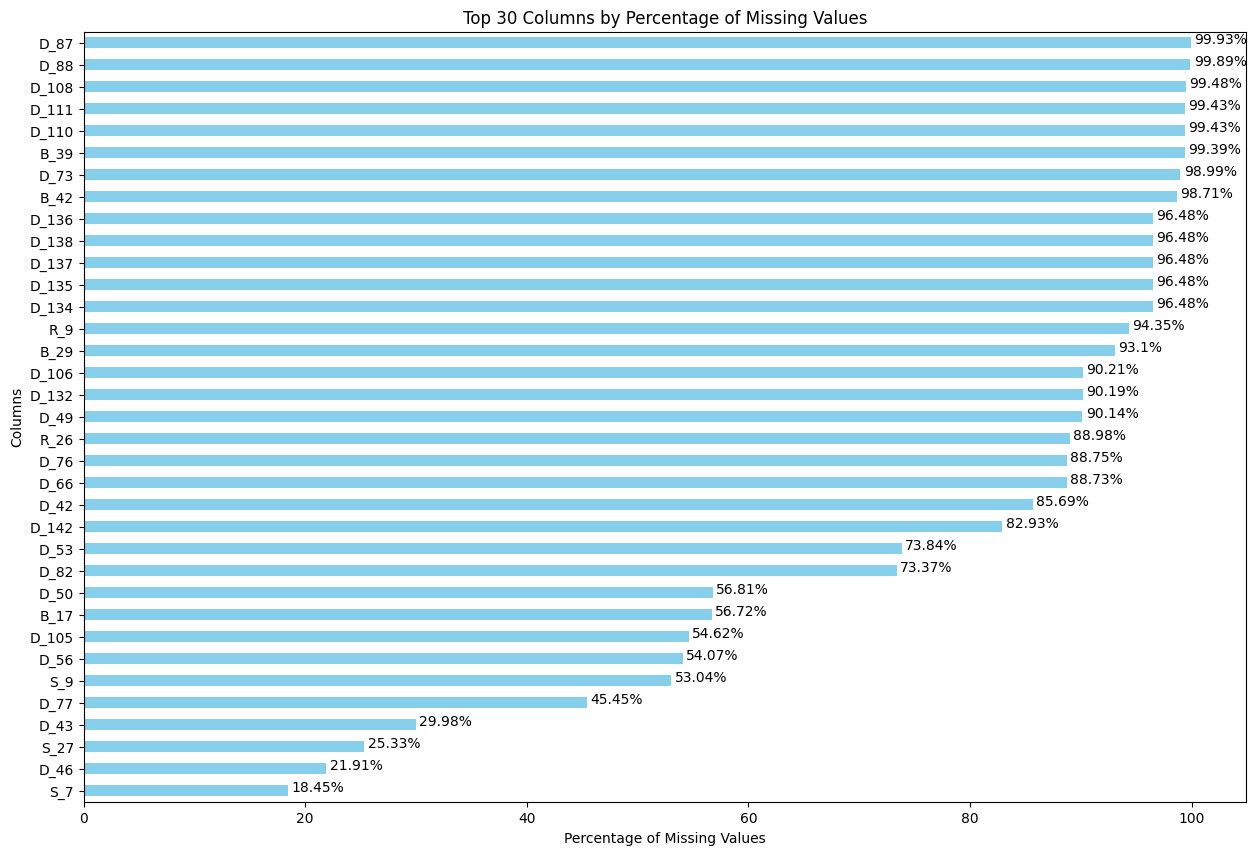

In [11]:
# Calculate the percentage of missing values for each column
missing_percent = (train.isna().sum() / len(train)) * 100

# Sort the values in descending order and select the top 30
missing_percent = missing_percent.sort_values(ascending=False).head(35)

# Create a horizontal bar chart for the top 30 columns
plt.figure(figsize=(15, 10))
ax = missing_percent.plot(kind='barh', color='skyblue')
for i in ax.patches:
    plt.text(i.get_width() + 0.3, i.get_y() + 0.1, str(round((i.get_width()), 2)) + '%', va='center')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns')
plt.title('Top 30 Columns by Percentage of Missing Values')
plt.gca().invert_yaxis()  # To display the highest percentage at the top
plt.show()


In [7]:
num_features = train.columns.difference(cat_features)
num_features

Index(['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17',
       'B_18',
       ...
       'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'customer_ID',
       'target'],
      dtype='object', length=180)

### Drop numerical features with missing value percentage over 50%

In [ ]:
# drop columns has more than 50% null, this method is more automatic. 
# def na_col(df):
#     del_cols = []
#     for col in df.columns:
#         if df[col].isna().sum() / df.shape[0] > 0.5:
#             del_cols.append(col)
#     return del_cols
# del_cols = na_col(df)
# print(f'delete {len(del_cols)} columns: {del_cols}')
# df_reduced = df.drop(columns = del_cols)

In [8]:
num_features = num_features.drop(labels = ['D_87', 'D_88', 'D_110', 'D_108', 'D_111', 'B_39', 'B_42', 'D_73', 'D_134','D_135','D_136','D_137','D_138',
                                           'R_9', 'B_29', 'D_106', 'D_132','D_49','R_26','D_76', 'D_42','D_142','D_53','D_82',  'B_17', 'D_105', 'D_56', 'S_9',
                                           'target', 'customer_ID', 'S_2'])
print(num_features)

Index(['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_18',
       'B_19',
       ...
       'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7',
       'S_8'],
      dtype='object', length=149)


In [14]:
print(train.dtypes)

customer_ID            object
S_2            datetime64[ns]
P_2                   float16
D_39                  float16
B_1                   float16
                    ...      
D_142                 float16
D_143                 float16
D_144                 float16
D_145                 float16
target                  int64
Length: 191, dtype: object


In [16]:
train.shape

(5531451, 191)

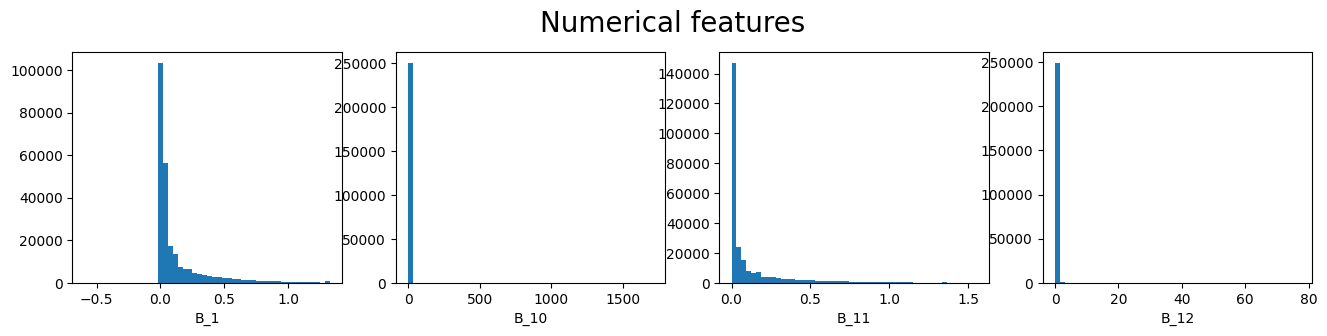

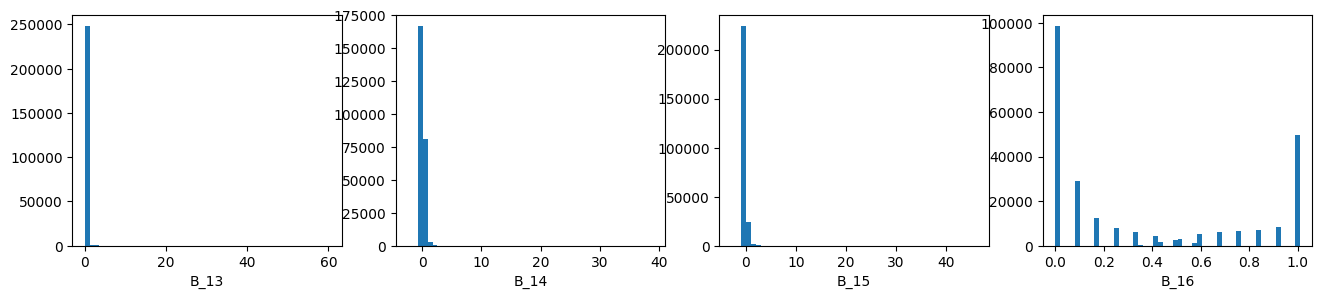

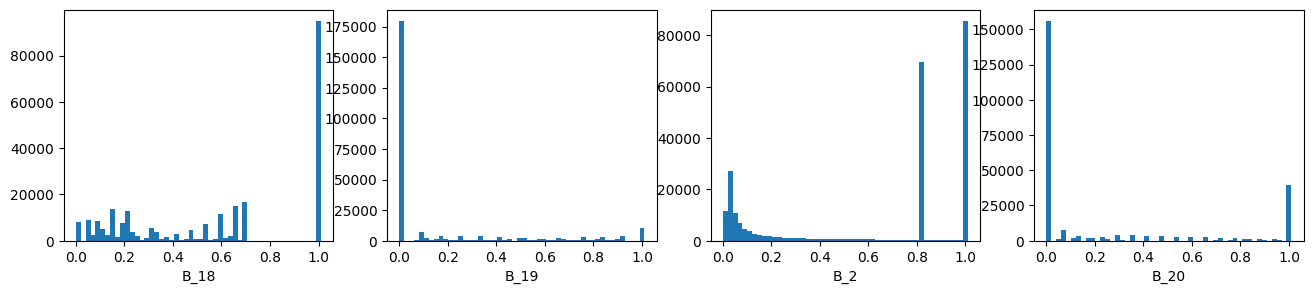

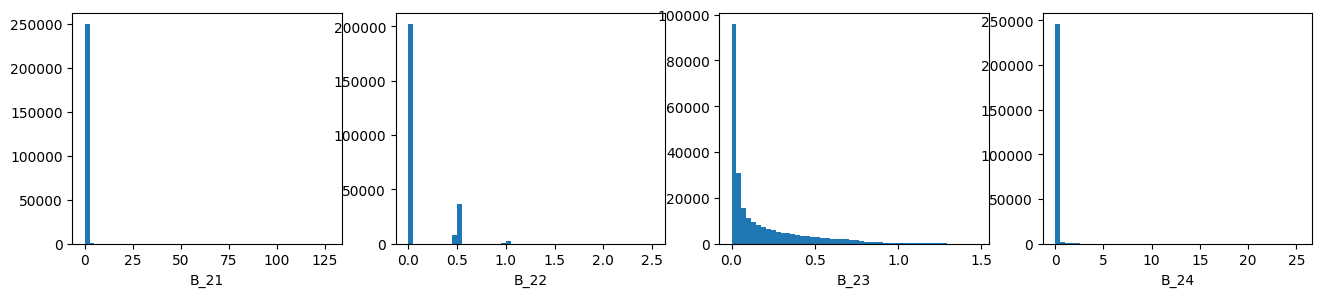

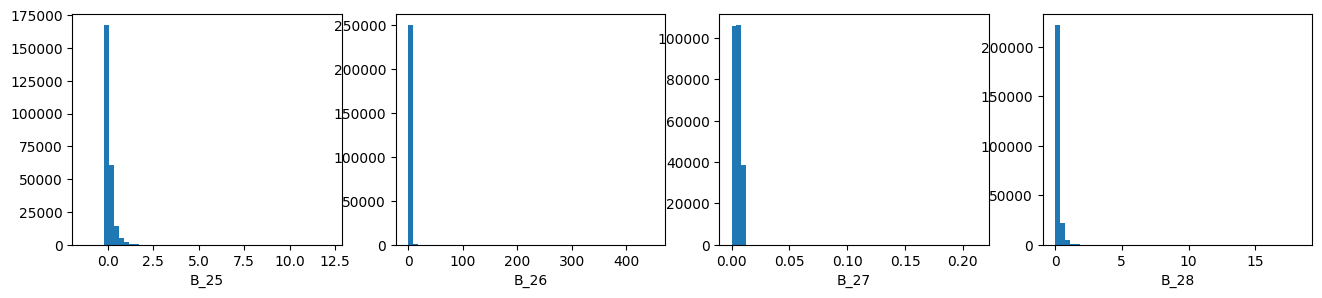

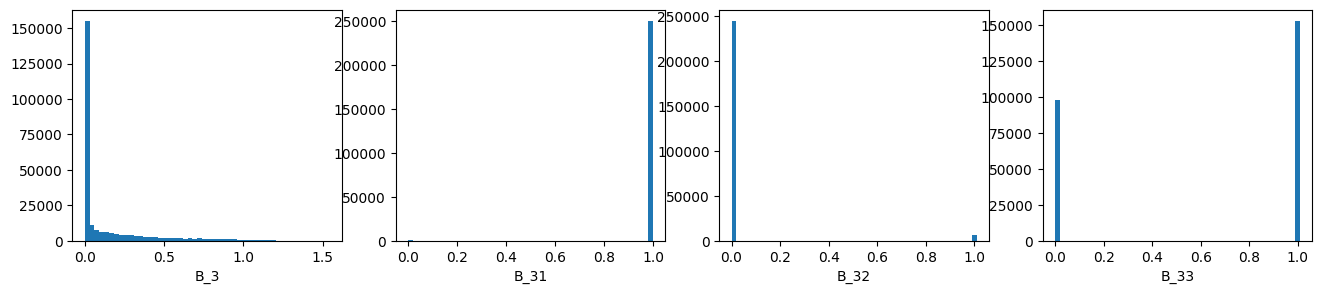

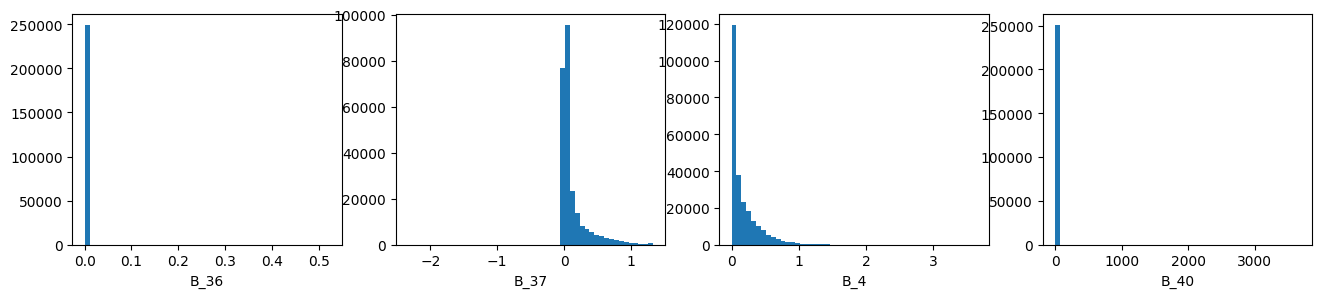

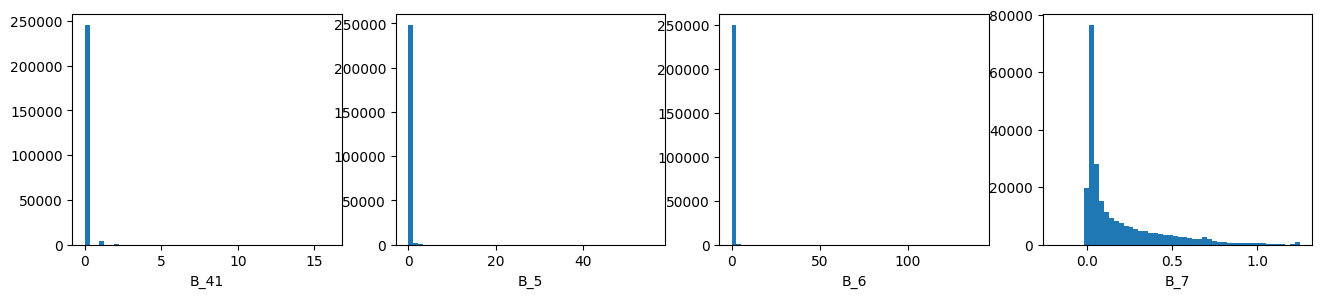

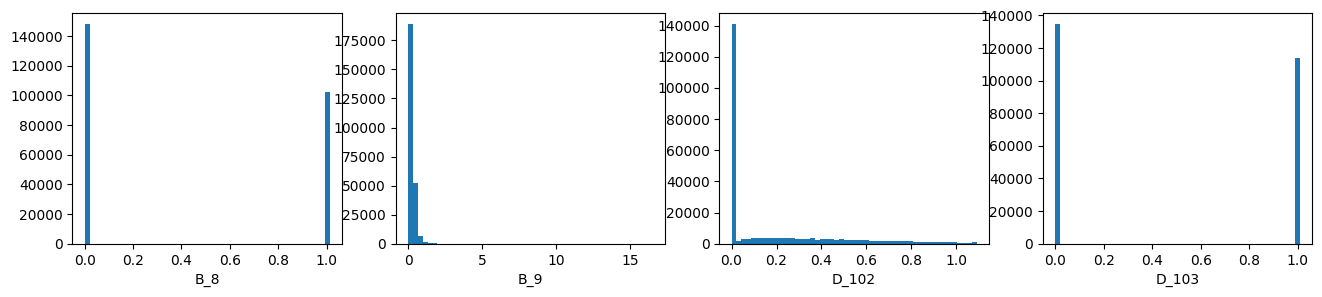

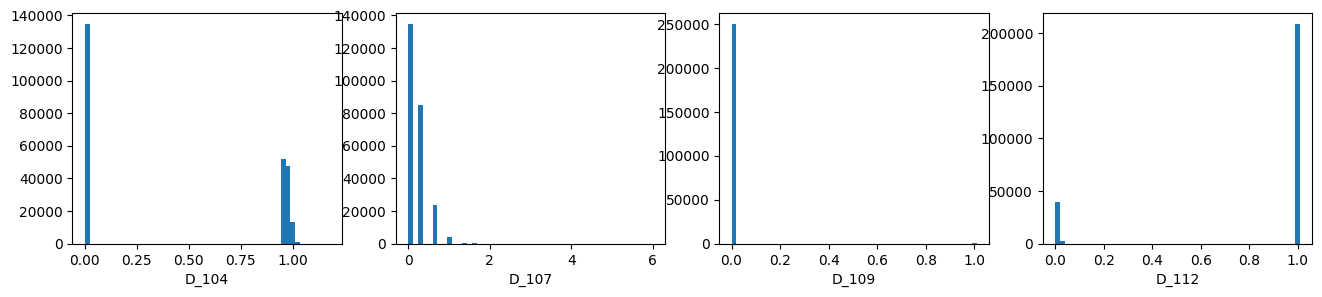

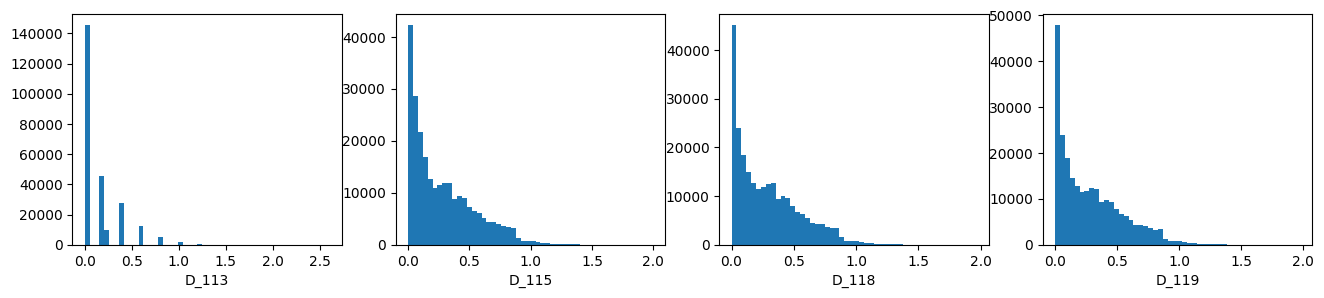

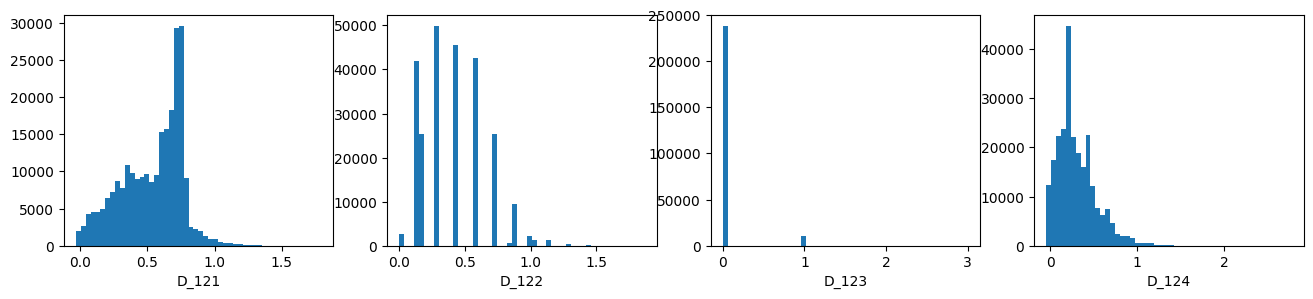

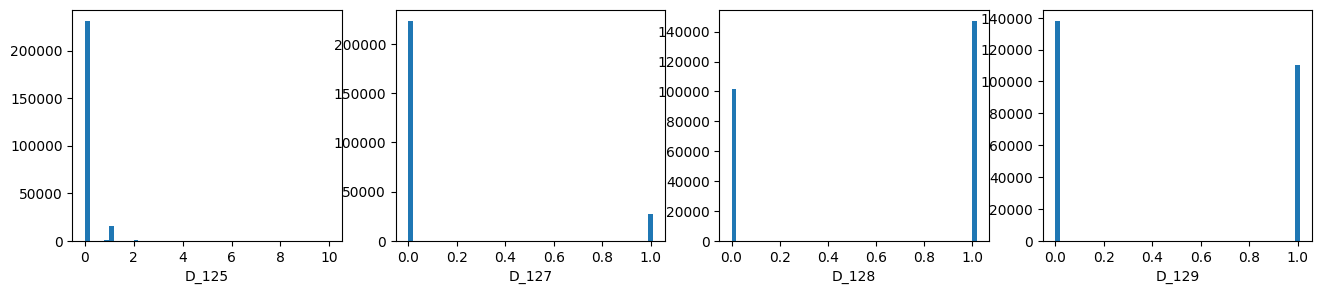

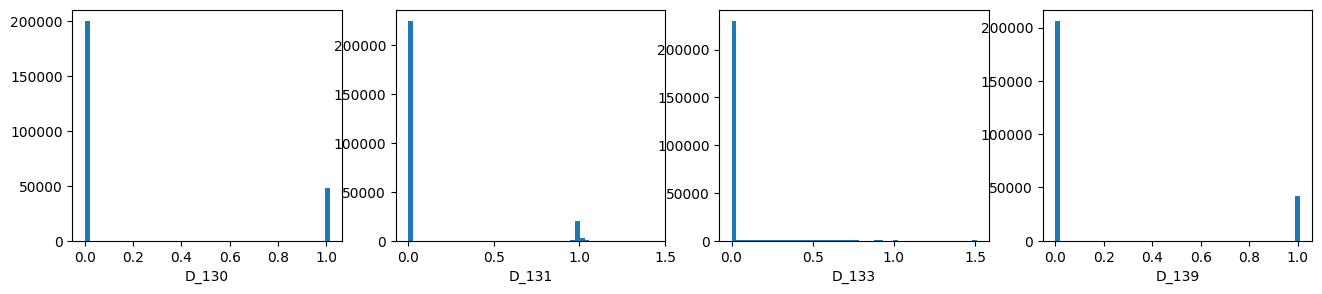

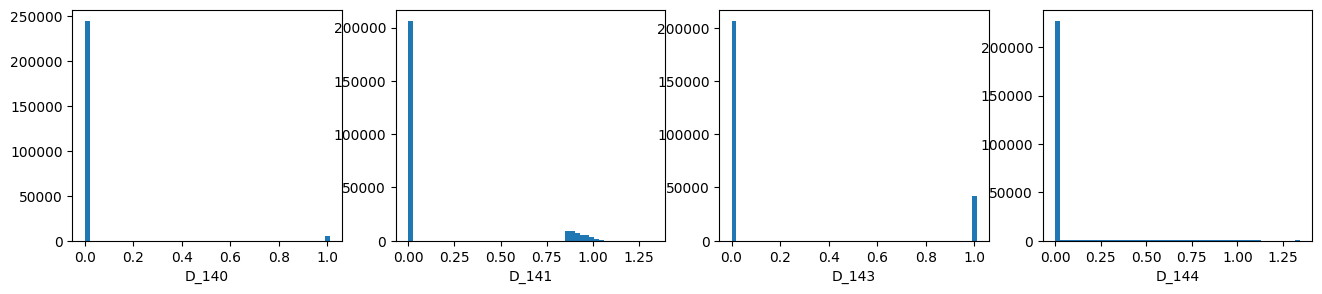

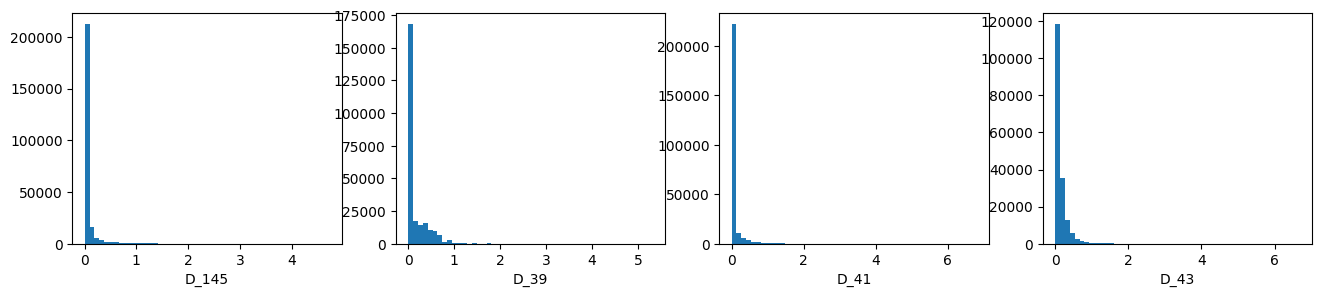

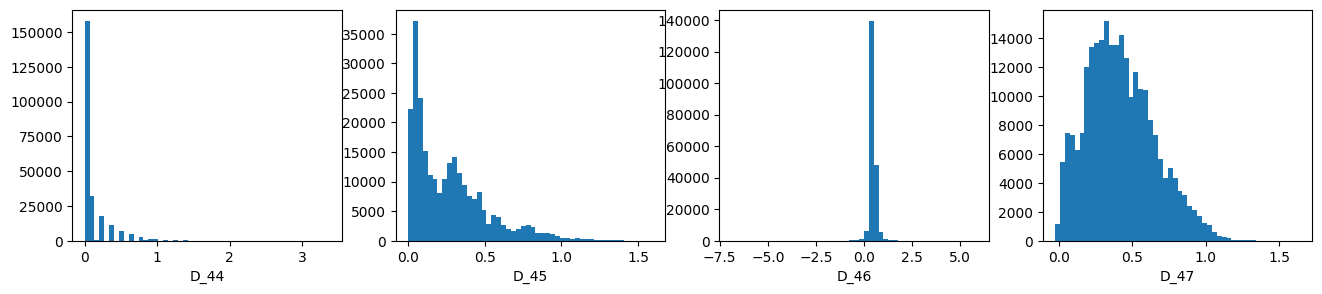

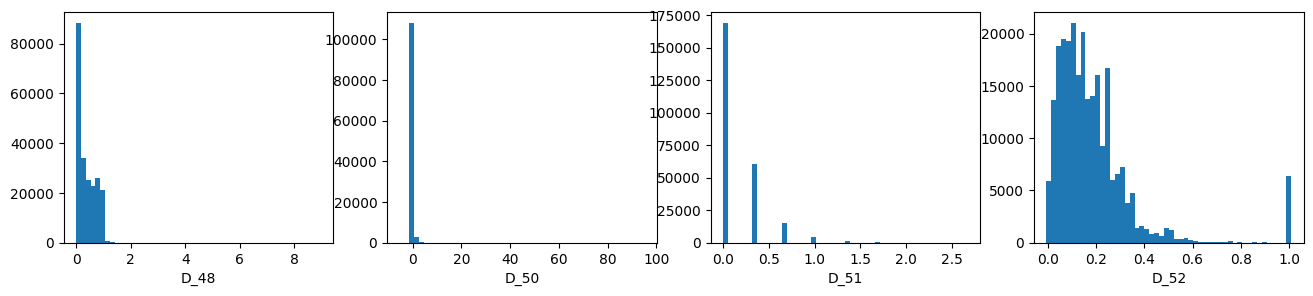

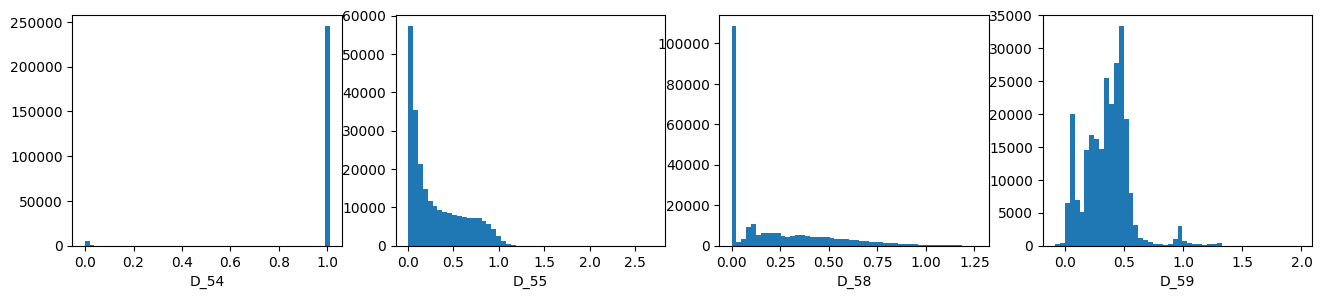

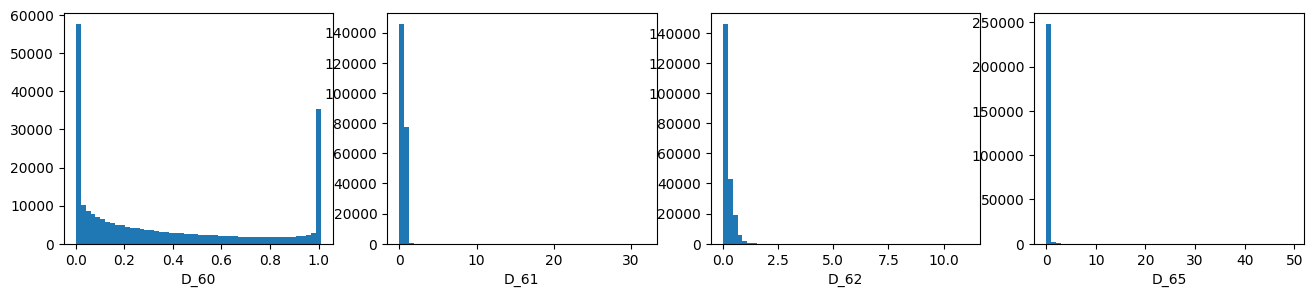

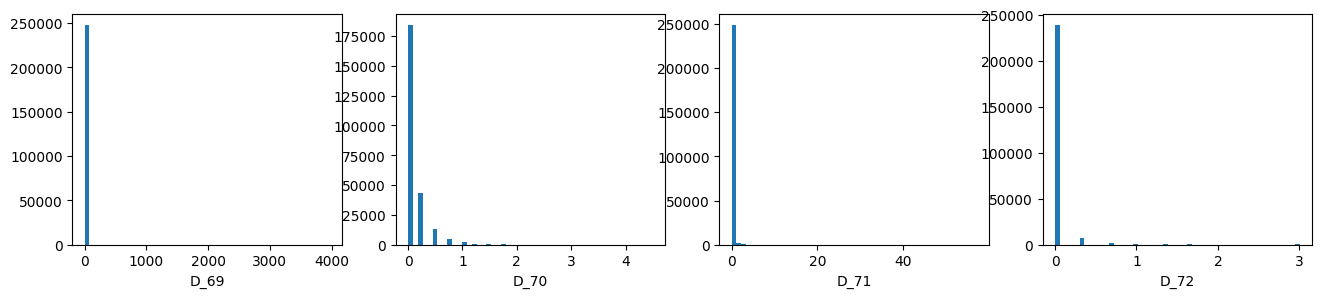

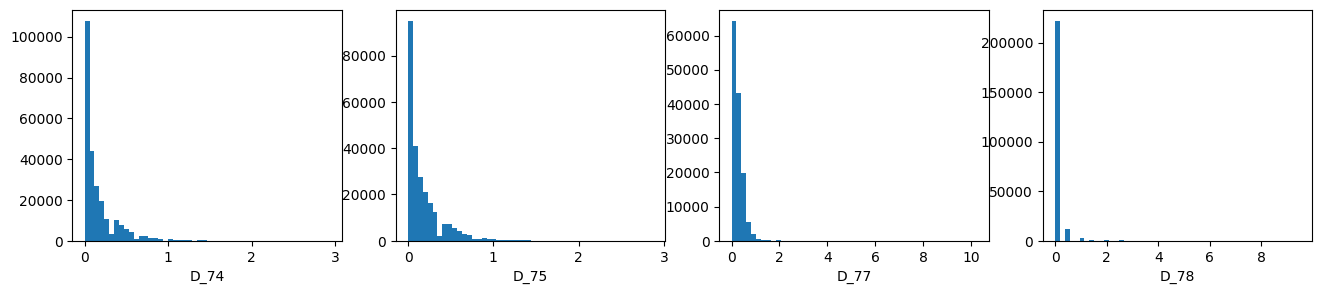

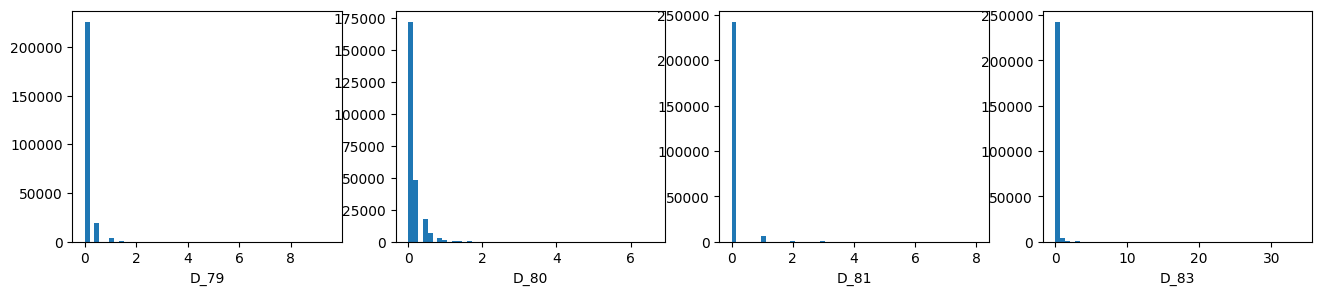

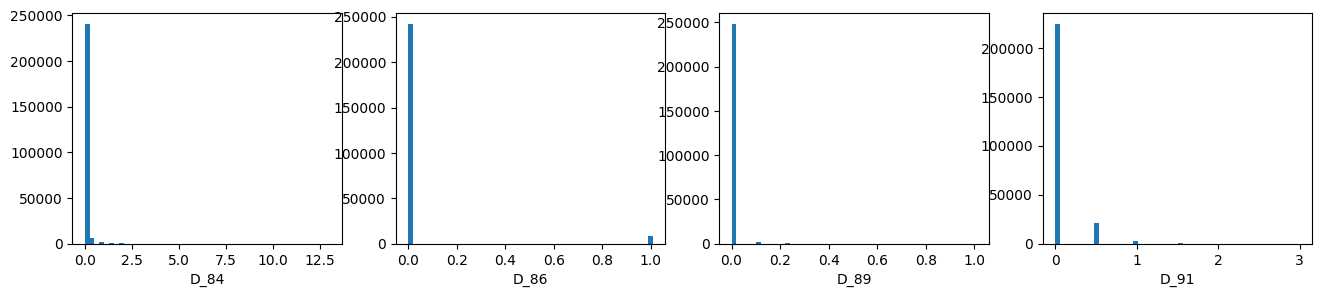

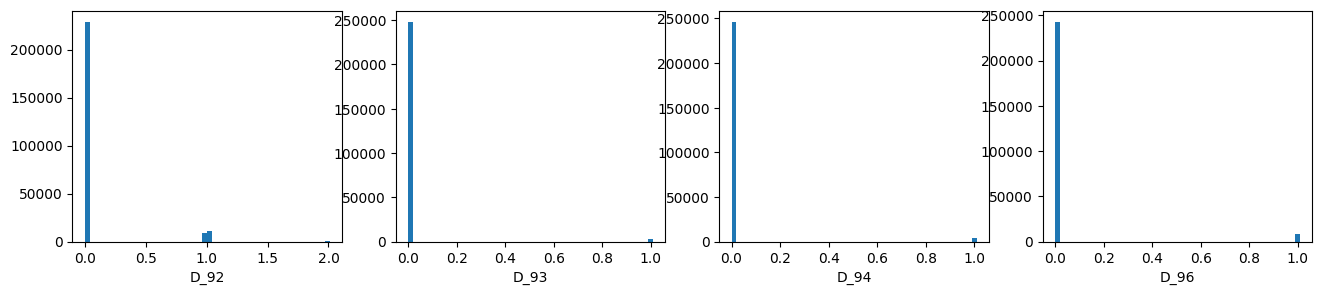

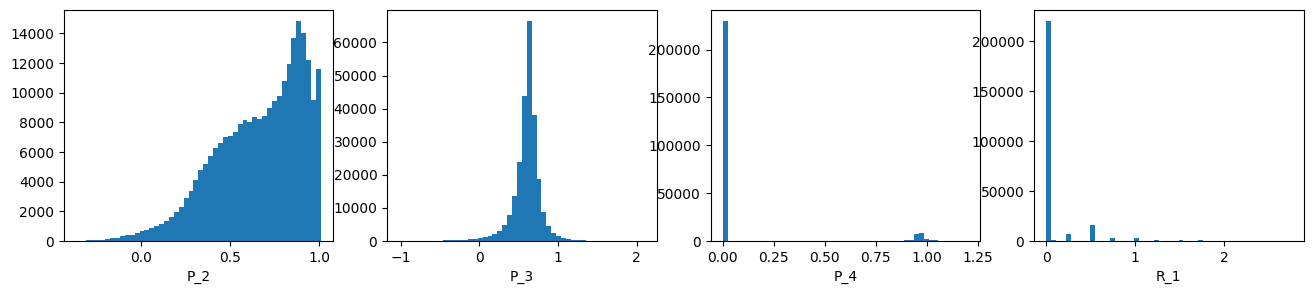

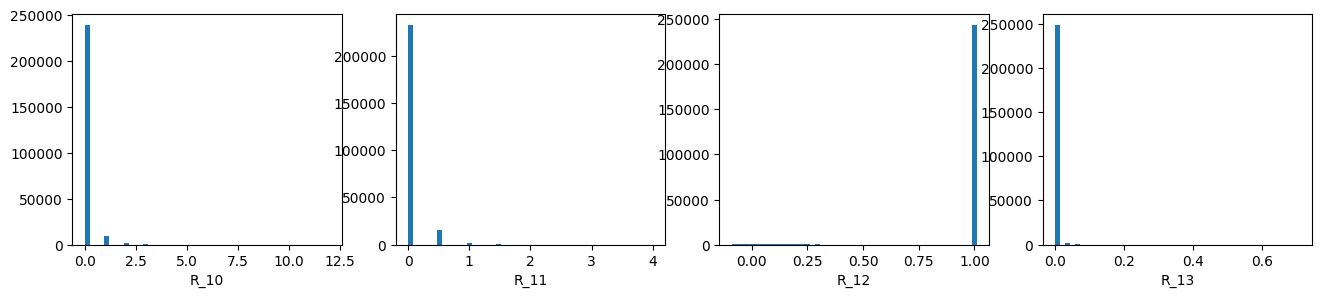

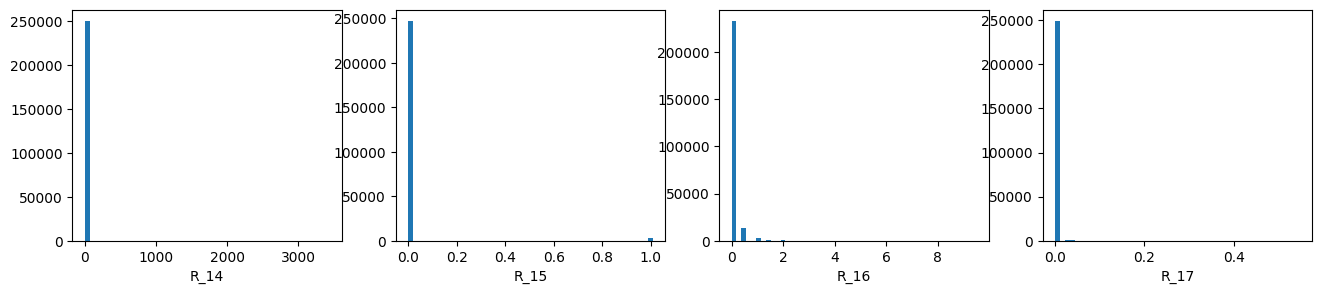

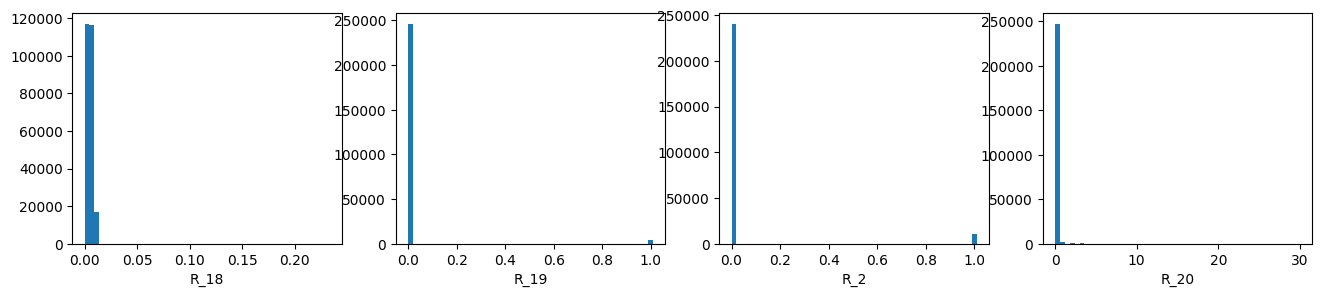

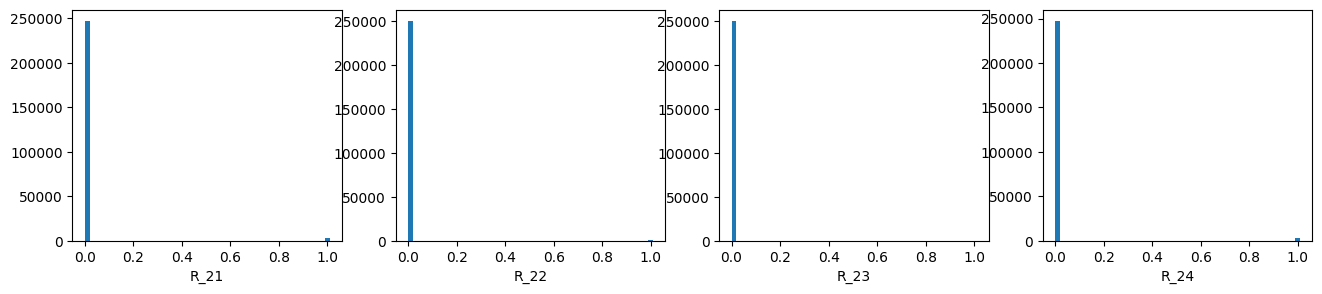

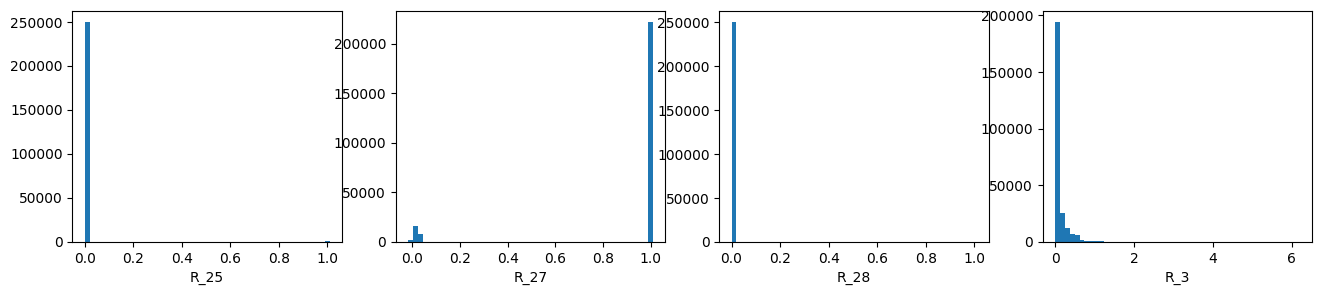

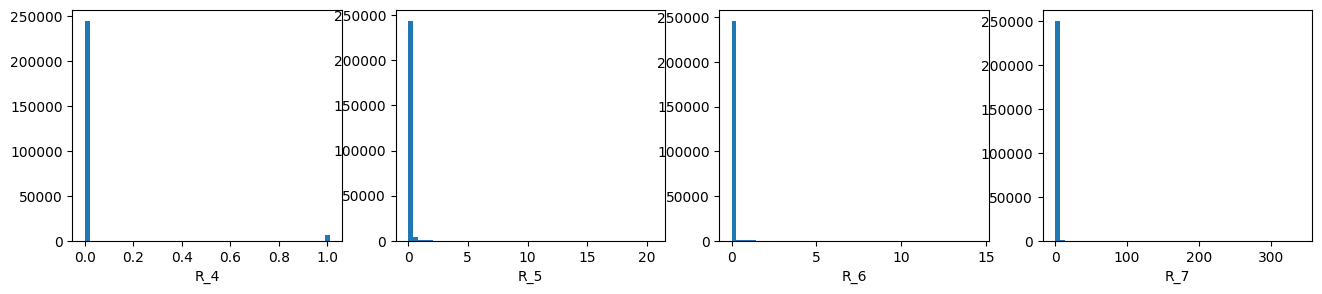

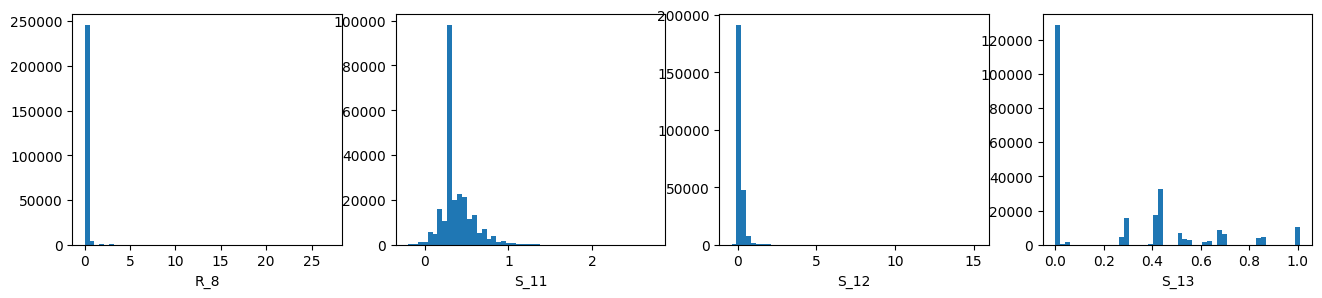

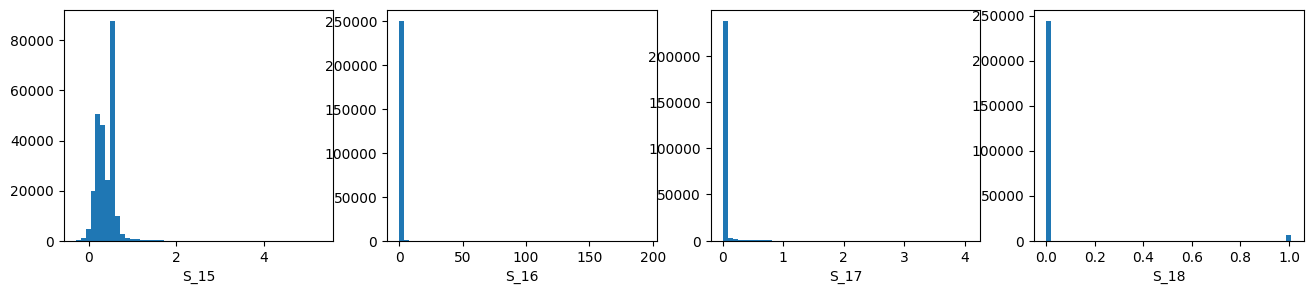

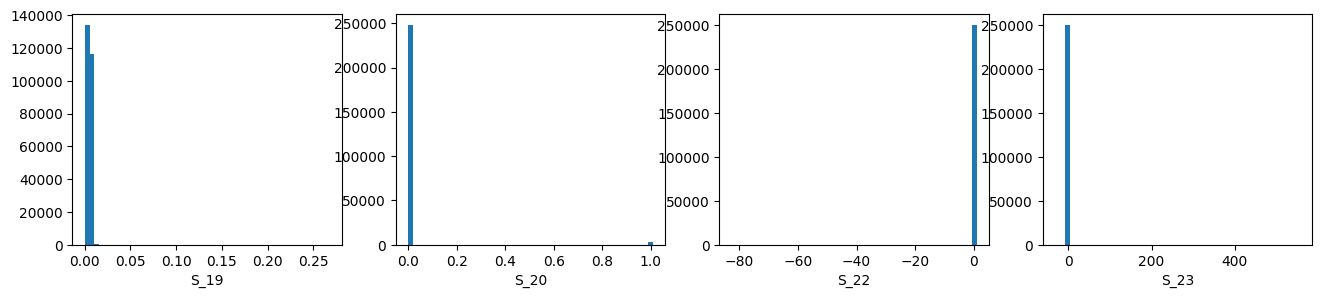

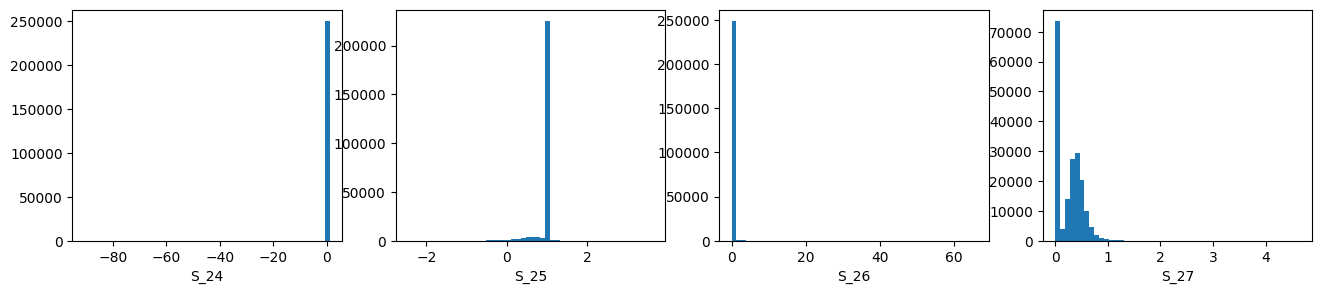

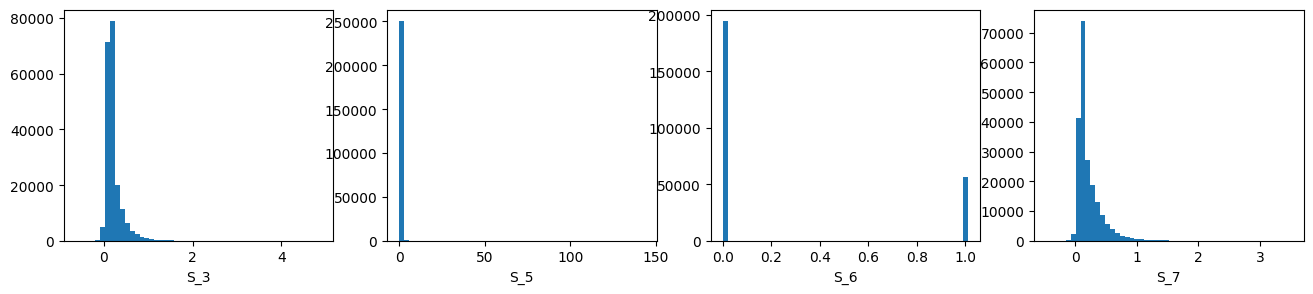

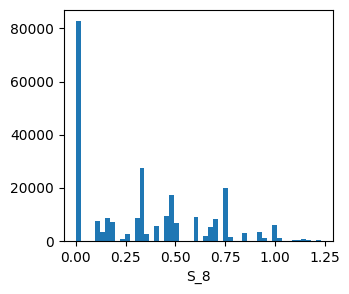

In [21]:
sample = train_filtered.sample(frac=0.05)
ncols = 4
for i, f in enumerate(num_features):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Numerical features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(sample[f], bins=50)
    plt.xlabel(f)
plt.show()

### Impute missing values with global mean of a feature

In [11]:
train_copy = train.copy()
for feature in num_features:
    median_value = train_copy[feature].median()
    train_copy.loc[train_copy[feature].isnull(), feature] = median_value


### Principal Component Analysis

In [12]:
num_features = list(num_features)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_copy[num_features])

B_features = [col for col in num_features if col.startswith('B')]
train_scaled_B = train_scaled[:, [num_features.index(col) for col in B_features]]

S_features = [col for col in num_features if col.startswith('S')]
train_scaled_S = train_scaled[:, [num_features.index(col) for col in S_features]]

D_features = [col for col in num_features if col.startswith('D')]
train_scaled_D = train_scaled[:, [num_features.index(col) for col in D_features]]

P_features = [col for col in num_features if col.startswith('P')]
train_scaled_P = train_scaled[:, [num_features.index(col) for col in P_features]]

R_features = [col for col in num_features if col.startswith('R')]
train_scaled_R = train_scaled[:, [num_features.index(col) for col in R_features]]

pca = PCA()
pca_features_B = pca.fit_transform(train_scaled_B)


### B features

In [27]:
len(B_features)

34

In [28]:
# get component loadings (correlation coefficient between original variables and the component) 
loadings_B = pca.components_
num_pc = pca.n_components_ # number prin compo
pc_list = ["PC"+str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame(loadings_B.T, columns=pc_list)
loadings_df['variable'] = B_features
loadings_df = loadings_df.set_index('variable')
# loadings_df


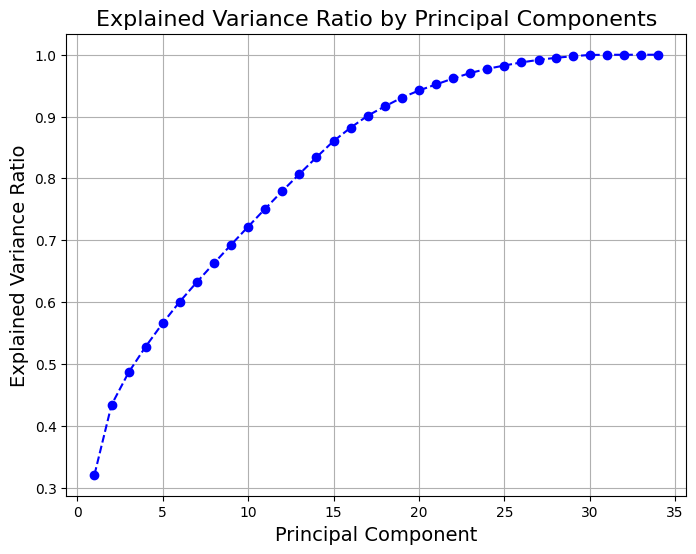

In [29]:

plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Components', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.grid(True)
plt.show()


### Top 17 PCs explained 90% of the variance

In [30]:
# cumulative_variance = pca.explained_variance_ratio_.cumsum()
# num_components_90_variance = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.90) + 1
# print(f'Number of components explaining 90% of variance: {num_components_90_variance}')


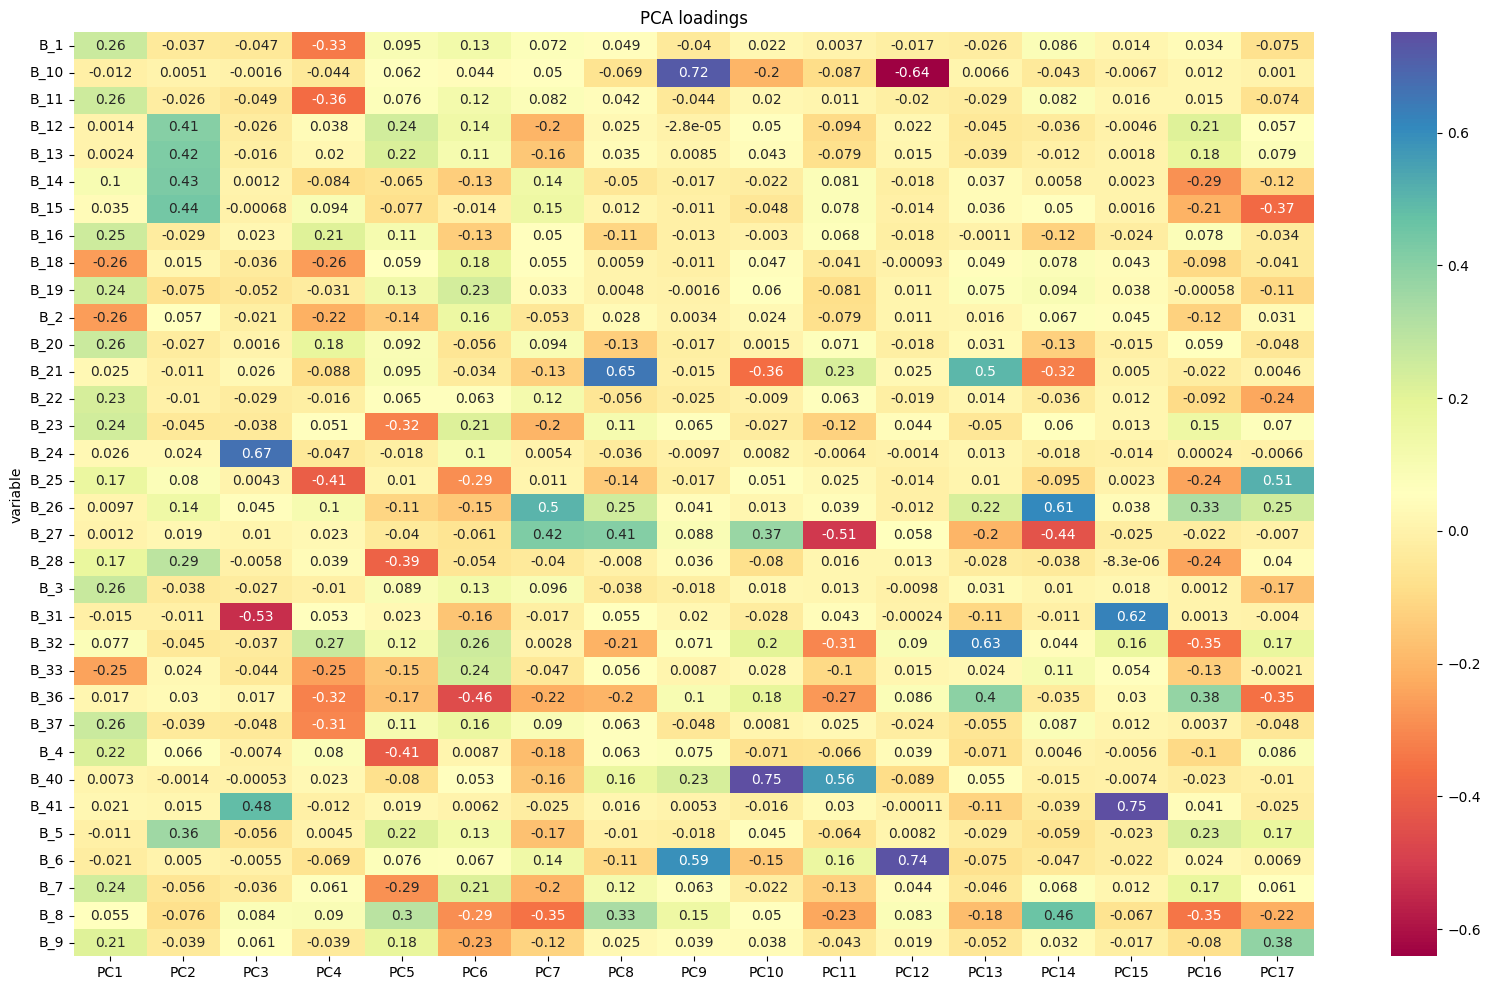

In [31]:
top_17_loadings_df = loadings_df.iloc[:, :17]
plt.figure(figsize=(20,12))
ax = sns.heatmap(top_17_loadings_df, annot=True, cmap='Spectral')
plt.title('PCA loadings')
plt.show()


In [13]:
B_features_filtered = ['B_10','B_21','B_24', 'B_26', 'B_27', 'B_31', 'B_32','B_40','B_41', 'B_6']

### S features

In [33]:
pca_features_S = pca.fit_transform(train_scaled_S)

# get component loadings (correlation coefficient between original variables and the component) 
loadings_S = pca.components_
num_pc = pca.n_components_ # number prin compo
pc_list = ["PC"+str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame(loadings_S.T, columns=pc_list)
loadings_df['variable'] = S_features
loadings_df = loadings_df.set_index('variable')

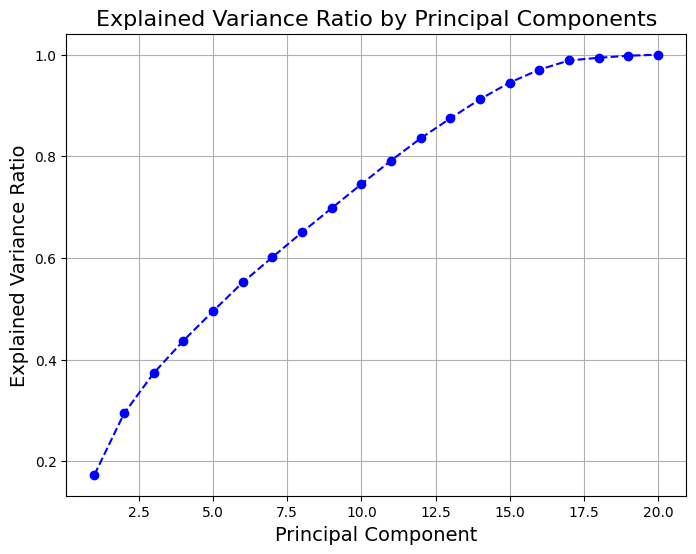

In [34]:
plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Components', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.grid(True)
plt.show()


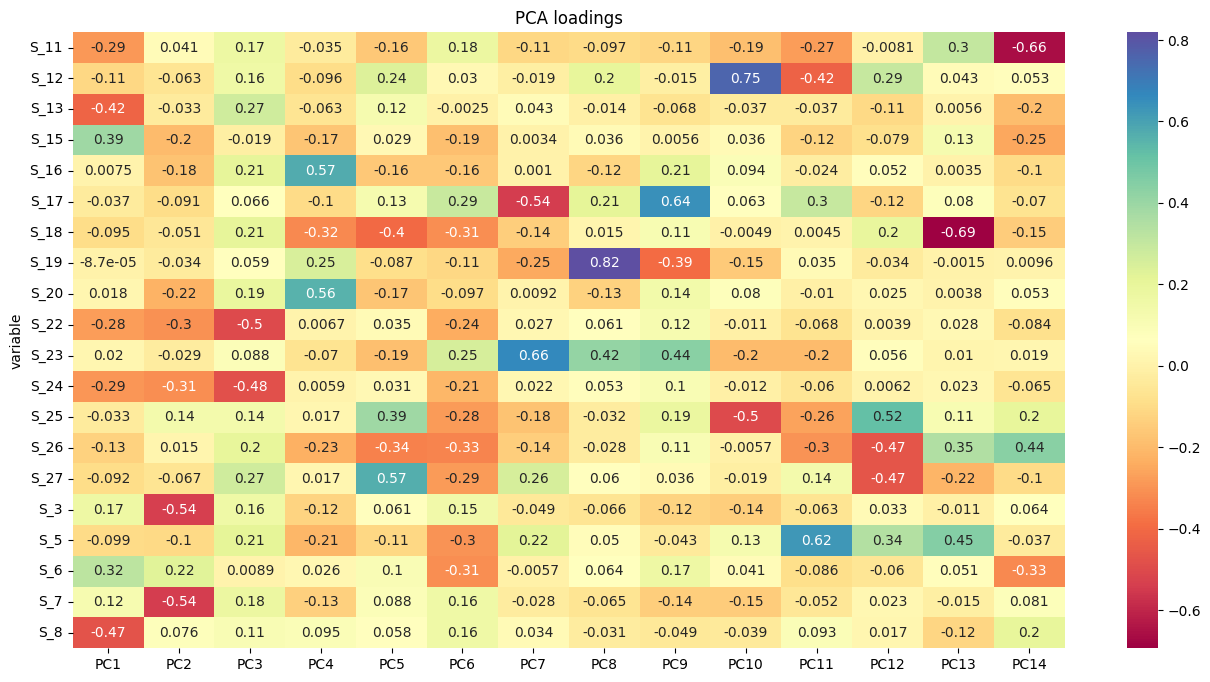

In [35]:
top_14_loadings_df = loadings_df.iloc[:, :14]
plt.figure(figsize=(16,8))
ax = sns.heatmap(top_14_loadings_df, annot=True, cmap='Spectral')
plt.title('PCA loadings')
plt.show()


In [14]:
S_features_filtered = ['S_11','S_12','S_16','S_17','S_18','S_19','S_23','S_25','S_26']

### D features

In [21]:
pca_features_D = pca.fit_transform(train_scaled_D)

# get component loadings (correlation coefficient between original variables and the component) 
loadings_D = pca.components_
num_pc = pca.n_components_ # number prin compo
pc_list = ["PC"+str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame(loadings_D.T, columns=pc_list)
loadings_df['variable'] = D_features
loadings_df = loadings_df.set_index('variable')

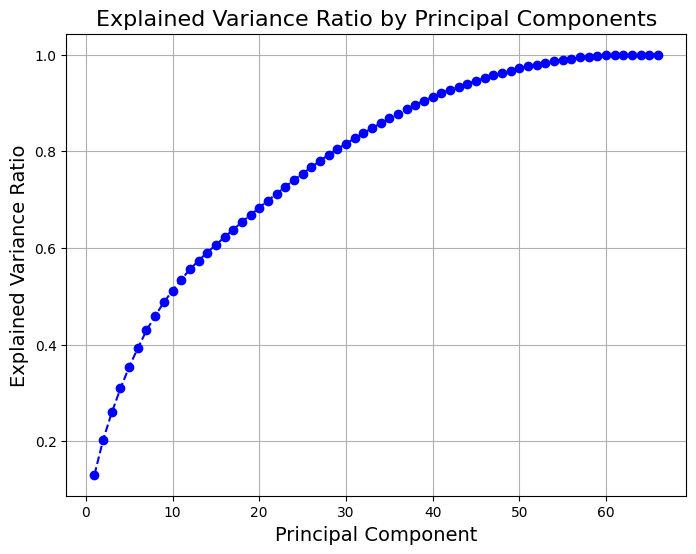

In [22]:
plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Components', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.grid(True)
plt.show()


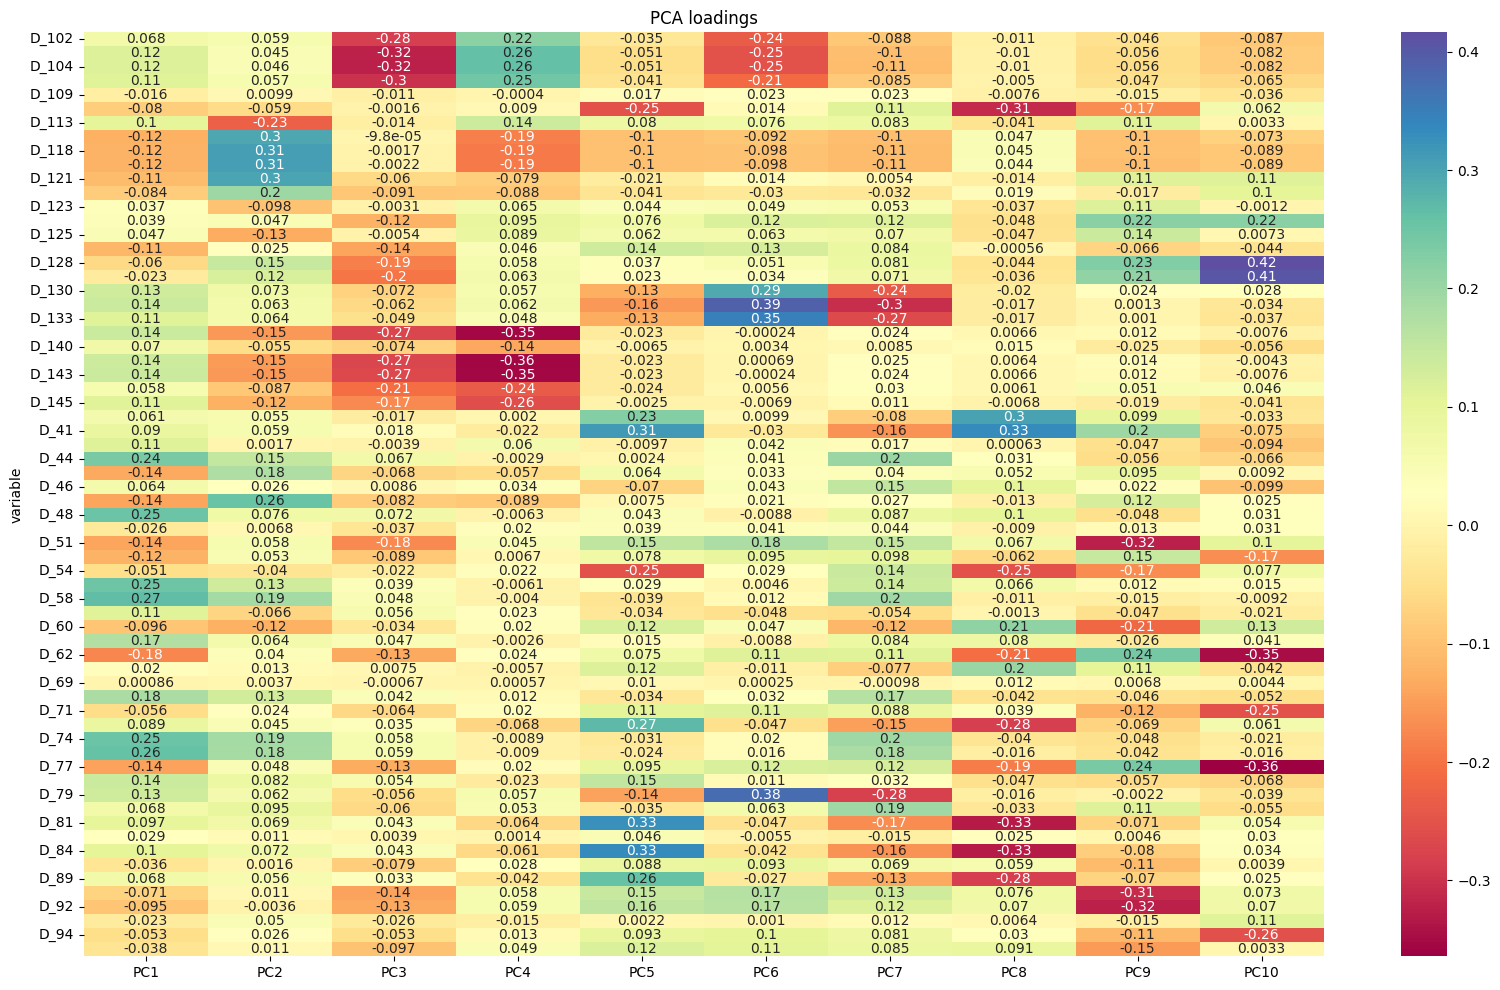

In [23]:
top_10_loadings_df = loadings_df.iloc[:, :10]
plt.figure(figsize=(20,12))
ax = sns.heatmap(top_10_loadings_df, annot=True, cmap='Spectral')
plt.title('PCA loadings')
plt.show()


In [15]:
D_features_filtered = ['D_102','D_104','D_109','D_128','D_130','D_133','D_89','D_92','D_143','D_48','D_54','D_62','D_77' ]

### P features

In [ ]:
pca_features_P = pca.fit_transform(train_scaled_P)

# get component loadings (correlation coefficient between original variables and the component) 
loadings_P = pca.components_
num_pc = pca.n_components_ # number prin compo
pc_list = ["PC"+str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame(loadings_P.T, columns=pc_list)
loadings_df['variable'] = P_features
loadings_df = loadings_df.set_index('variable')


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Components', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
# top_20_loadings_df = loadings_df.iloc[:, :20]
plt.figure(figsize=(8,6))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.title('PCA loadings')
plt.show()


In [16]:
P_features_filtered = ['P_2','P_3','P_4']

### R features

In [18]:
pca_features_R = pca.fit_transform(train_scaled_R)

# get component loadings (correlation coefficient between original variables and the component) 
loadings_R = pca.components_
num_pc = pca.n_components_ # number prin compo
pc_list = ["PC"+str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame(loadings_R.T, columns=pc_list)
loadings_df['variable'] = R_features
loadings_df = loadings_df.set_index('variable')

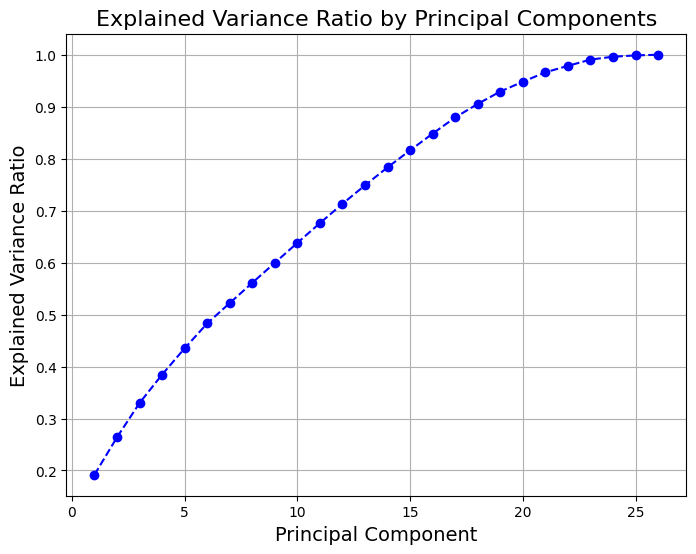

In [19]:
plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.title('Explained Variance Ratio by Principal Components', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.grid(True)
plt.show()

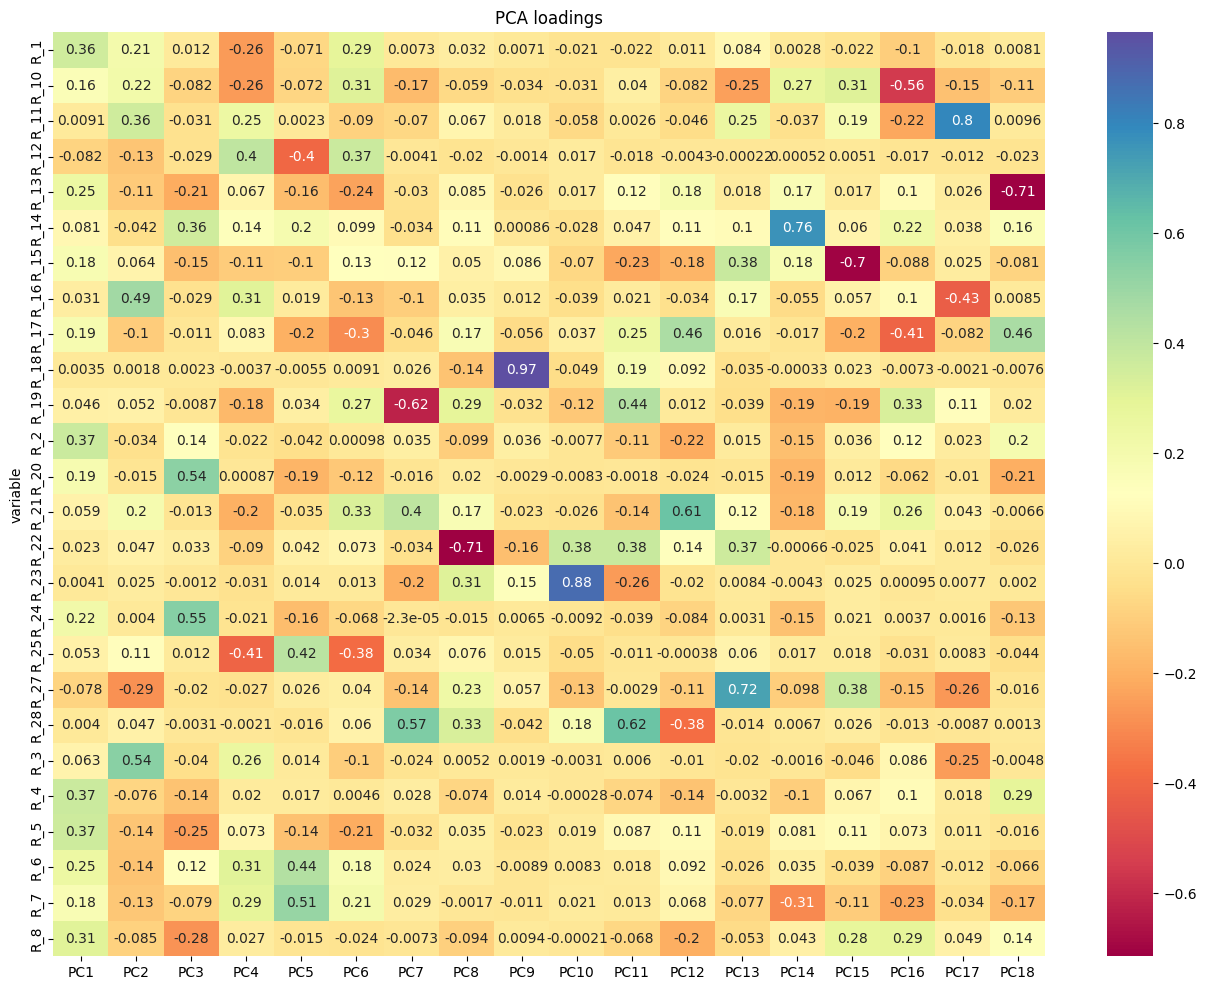

In [20]:
top_18_loadings_df = loadings_df.iloc[:, :18]
plt.figure(figsize=(16,12))
ax = sns.heatmap(top_18_loadings_df, annot=True, cmap='Spectral')
plt.title('PCA loadings')
plt.show()

In [24]:
R_features_filtered = ['R_11','R_13','R_14','R_15','R_17','R_18','R_22','R_23','R_27','R_28']

In [25]:
features_to_keep = R_features_filtered + B_features_filtered + S_features_filtered + D_features_filtered + P_features_filtered + cat_features
len(features_to_keep)

56

In [26]:
features_to_keep.remove('D_66')

In [27]:
features_for_modeling = features_to_keep + ['target', 'customer_ID', 'S_2']
features_for_modeling

['R_11',
 'R_13',
 'R_14',
 'R_15',
 'R_17',
 'R_18',
 'R_22',
 'R_23',
 'R_27',
 'R_28',
 'B_10',
 'B_21',
 'B_24',
 'B_26',
 'B_27',
 'B_31',
 'B_32',
 'B_40',
 'B_41',
 'B_6',
 'S_11',
 'S_12',
 'S_16',
 'S_17',
 'S_18',
 'S_19',
 'S_23',
 'S_25',
 'S_26',
 'D_102',
 'D_104',
 'D_109',
 'D_128',
 'D_130',
 'D_133',
 'D_89',
 'D_92',
 'D_143',
 'D_48',
 'D_54',
 'D_62',
 'D_77',
 'P_2',
 'P_3',
 'P_4',
 'B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_68',
 'target',
 'customer_ID',
 'S_2']

In [28]:
train_filtered = train[features_for_modeling]

In [29]:
train_filtered.shape

(5531451, 58)

In [23]:
train_filtered.head()

,R_11,R_13,R_14,R_15,R_17,R_18,R_22,R_23,R_27,R_28,...,D_116,D_117,D_120,D_126,D_63,D_64,D_68,target,customer_ID,S_2
0,0.002457,0.003820,0.000438,0.006451,0.000198,0.008911,0.007481,0.006893,1.008789,0.001534,...,0.0,4.0,0.0,1.0,CR,O,6.0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09
1,0.000395,0.000347,0.004311,0.002333,0.001143,0.005905,0.006828,0.002836,1.002930,0.004932,...,0.0,4.0,0.0,1.0,CR,O,6.0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07
2,0.007347,0.002710,0.007141,0.008362,0.008011,0.008881,0.009819,0.005081,1.000977,0.009125,...,0.0,4.0,0.0,1.0,CR,O,6.0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28
3,0.004963,0.009979,0.008690,0.007362,0.009453,0.008347,0.000458,0.007320,1.004883,0.002409,...,0.0,4.0,0.0,1.0,CR,O,6.0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13
4,0.002247,0.005859,0.007812,0.002470,0.002018,0.002678,0.003342,0.000264,1.002930,0.004463,...,0.0,4.0,0.0,1.0,CR,O,6.0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16


#### Impute missing values

In [30]:
train_filtered.isnull().sum()

R_11                 0
R_13                 0
R_14                 1
R_15                 0
R_17                 0
R_18                 0
R_22                 0
R_23                 0
R_27            128703
R_28                 0
B_10                 0
B_21                 0
B_24                 0
B_26              2016
B_27              2016
B_31                 0
B_32                 0
B_40                53
B_41               690
B_6                233
S_11                 0
S_12                 0
S_16                 0
S_17                 0
S_18                 0
S_19                 0
S_23               445
S_25             12847
S_26               634
D_102            40655
D_104           101548
D_109             1597
D_128           101548
D_130           101548
D_133            42716
D_89             29563
D_92                 0
D_143           101548
D_48            718725
D_54              2016
D_62            758161
D_77           2513912
P_2              45985
P_3        

In [ ]:
# impute numerical variables
# num_cols = df_reduced.columns[2:-1]
# num_cols = [col for col in num_cols if col not in cat_cols]
# print(f"impute {len(num_cols)} numerical columns")
# imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
# data_imputed = imputer.fit_transform(df_reduced[num_cols])
# df_numeric_imputed = pd.DataFrame(data_imputed, columns = num_cols)

In [ ]:
train_filtered.isnull().sum()

### Feature Engineering / Aggregation

In [31]:
train_filtered.columns

Index(['R_11', 'R_13', 'R_14', 'R_15', 'R_17', 'R_18', 'R_22', 'R_23', 'R_27',
       'R_28', 'B_10', 'B_21', 'B_24', 'B_26', 'B_27', 'B_31', 'B_32', 'B_40',
       'B_41', 'B_6', 'S_11', 'S_12', 'S_16', 'S_17', 'S_18', 'S_19', 'S_23',
       'S_25', 'S_26', 'D_102', 'D_104', 'D_109', 'D_128', 'D_130', 'D_133',
       'D_89', 'D_92', 'D_143', 'D_48', 'D_54', 'D_62', 'D_77', 'P_2', 'P_3',
       'P_4', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126',
       'D_63', 'D_64', 'D_68', 'target', 'customer_ID', 'S_2'],
      dtype='object')

In [32]:
cat_features.remove('D_66')

In [33]:
cat_features

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_68']

In [34]:
dummy = pd.get_dummies(train_filtered[cat_features], drop_first=True)
train_filtered.drop(columns=cat_features, inplace=True)
train_filtered = pd.concat([train_filtered, dummy], axis = 1)
train_filtered.head(5)

/var/tmp/ipykernel_3093/3763187055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered.drop(columns=cat_features, inplace=True)


,R_11,R_13,R_14,R_15,R_17,R_18,R_22,R_23,R_27,R_28,...,D_64_-1,D_64_O,D_64_R,D_64_U,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,0.002457,0.003820,0.000438,0.006451,0.000198,0.008911,0.007481,0.006893,1.008789,0.001534,...,False,True,False,False,False,False,False,False,False,True
1,0.000395,0.000347,0.004311,0.002333,0.001143,0.005905,0.006828,0.002836,1.002930,0.004932,...,False,True,False,False,False,False,False,False,False,True
2,0.007347,0.002710,0.007141,0.008362,0.008011,0.008881,0.009819,0.005081,1.000977,0.009125,...,False,True,False,False,False,False,False,False,False,True
3,0.004963,0.009979,0.008690,0.007362,0.009453,0.008347,0.000458,0.007320,1.004883,0.002409,...,False,True,False,False,False,False,False,False,False,True
4,0.002247,0.005859,0.007812,0.002470,0.002018,0.002678,0.003342,0.000264,1.002930,0.004463,...,False,True,False,False,False,False,False,False,False,True


In [35]:
aggregated_data = train_filtered.groupby('customer_ID').agg({
    col: ['mean', 'max', 'std'] for col in train_filtered.columns if col not in ['S_2','target','customer_ID'] + cat_features
})

aggregated_data['S_2_latest'] = train_filtered.groupby('customer_ID')['S_2'].max()
aggregated_data['target'] = train_filtered.groupby('customer_ID')['target'].max()

# Step 2: Flatten the hierarchical column names created by aggregation
aggregated_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_data.columns]

# Step 3: Reset the index so that 'customer_ID' is a column in the resulting DataFrame
aggregated_data.reset_index(inplace=True)

# Step 4: Check the shape or a sample of the aggregated data
print(aggregated_data.shape)
print(aggregated_data.head(5))


/var/tmp/ipykernel_3093/2697004304.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregated_data['S_2_latest'] = train_filtered.groupby('customer_ID')['S_2'].max()


(458913, 240)
                                         customer_ID  R_11_mean  R_11_max  \
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...   0.004784  0.009354   
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...   0.044756  0.504883   
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...   0.004806  0.009933   
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...   0.044092  0.507324   
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...   0.043878  0.506348   

   R_11_std  R_13_mean  R_13_max  R_13_std  R_14_mean  R_14_max  R_14_std  \
0  0.002913   0.004522  0.009979  0.003461   0.005878  0.008781  0.002731   
1  0.138286   0.004322  0.008728  0.002631   0.005675  0.009895  0.003579   
2  0.003438   0.004913  0.009781  0.003666   0.005069  0.008667  0.002535   
3  0.139207   0.005827  0.009476  0.002829   0.005832  0.009979  0.003102   
4  0.138988   0.004697  0.009018  0.003280   0.005332  0.009026  0.002236   

   ...  D_68_4.0_max  D_68_4.0_std  D_68_5.0_mean  D_68_5.0_

/var/tmp/ipykernel_3093/2697004304.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregated_data['target'] = train_filtered.groupby('customer_ID')['target'].max()
/var/tmp/ipykernel_3093/2697004304.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggregated_data.reset_index(inplace=True)


In [ ]:
filename = './aggregated_data'
outfile = open(filename,'wb')
pickle.dump(models_to_save, outfile)
outfile.close()

### AutoGluon Model

In [40]:
train_data1, test_data = train_test_split(aggregated_data, test_size=0.2, random_state=42)
train_data, eval_data = train_test_split(train_data1, test_size=0.1, random_state=42)

In [ ]:
# X = aggregated_data.drop(columns=['target_'])
# y = aggregated_data['target_']
# X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.1, random_state=42)

In [42]:
# hyperparameter_tune_kwargs = {  
#     'num_trials': 20,
#     'scheduler' : 'local',
#     'searcher'  : 'auto',
# }
predictor = TabularPredictor(label = 'target_', eval_metric = 'roc_auc')
predictor.fit(train_data,
              time_limit = 3600,
              presets = 'best_quality',
              num_bag_folds=5,  # Number of bagging folds
              num_bag_sets=1,  # Number of repeats for bagging
              num_stack_levels=1,  # Number of stacking levels, set 1 for single layer
            # tuning_data=eval_data
              # save_space = True,
              # keep_only_best = False,
             )
leaderboard = predictor.leaderboard(test_data)
y_preds = predictor.predict_proba(test_data, as_multiclass=False)


No path specified. Models will be saved in: "AutogluonModels/ag-20241003_235357"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.223-1 (2024-08-10)
CPU Count:          16
Memory Avail:       101.83 GB / 125.81 GB (80.9%)
Disk Space Avail:   77.75 GB / 97.87 GB (79.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subs

In [43]:
predictor = TabularPredictor.load("AutogluonModels/ag-20241003_235357")

In [44]:
performance = predictor.evaluate(eval_data)
performance

{'roc_auc': 0.947938209596791,
 'accuracy': 0.886389017514232,
 'balanced_accuracy': 0.8517147570266863,
 'mcc': 0.7035020288104993,
 'f1': 0.7800917382822797,
 'precision': 0.780215144484286,
 'recall': 0.7799683711122826}

In [47]:
leaderboard

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.947423,0.947441,roc_auc,150.845840,652.922365,1221.831911,0.007338,0.068204,26.335536,3,True,18
1,LightGBMXT_BAG_L2,0.947383,0.947230,roc_auc,147.605057,604.140571,1122.825257,1.911559,2.637811,59.677537,2,True,10
2,WeightedEnsemble_L2,0.947349,0.947371,roc_auc,16.551429,24.820941,729.672138,0.004898,0.067110,13.284050,2,True,9
3,LightGBM_BAG_L2,0.947319,0.947198,roc_auc,147.023494,602.966996,1098.655377,1.329996,1.464236,35.507657,2,True,11
4,XGBoost_BAG_L2,0.947273,0.946382,roc_auc,151.952816,605.837539,1119.230434,6.259317,4.334779,56.082714,2,True,17
5,CatBoost_BAG_L2,0.947239,0.947161,roc_auc,151.354932,606.028473,1121.016532,5.661433,4.525713,57.868812,2,True,14
6,CatBoost_BAG_L1,0.947183,0.946949,roc_auc,5.860527,4.174256,420.575269,5.860527,4.174256,420.575269,1,True,7
7,LightGBMXT_BAG_L1,0.947011,0.946560,roc_auc,6.633104,13.261131,175.204762,6.633104,13.261131,175.204762,1,True,3
8,LightGBM_BAG_L1,0.946483,0.946227,roc_auc,4.052900,7.318444,120.608058,4.052900,7.318444,120.608058,1,True,4
9,RandomForestEntr_BAG_L2,0.946156,0.945381,roc_auc,147.544371,650.517545,1223.202809,1.850873,49.014786,160.055089,2,True,13


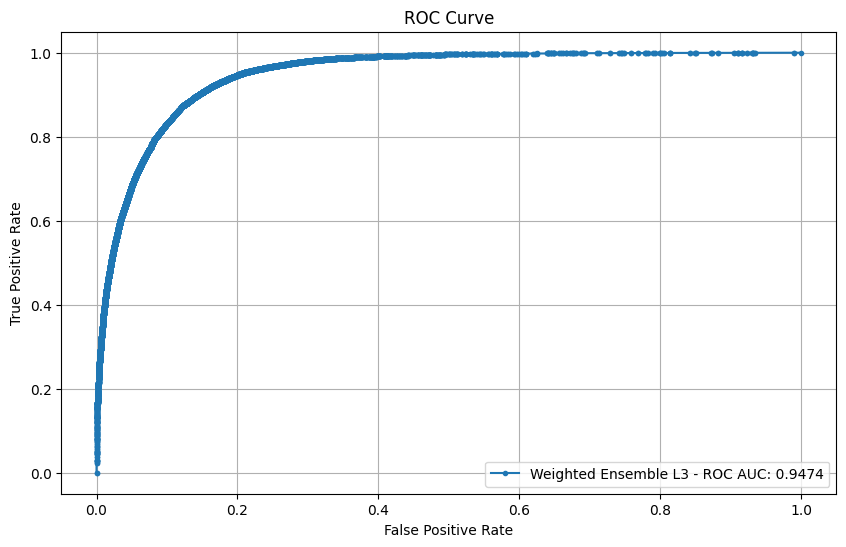

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
roc_auc = np.round(roc_auc, 4)

# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'Weighted Ensemble L3 - ROC AUC: {roc_auc}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
